In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, TensorDataset

Consider some target function $f:\mathbb{R}\to\mathbb{R}$, and a compact domain $D\subset \mathbb{R}$. Let $p_x$ be the uniform distribution over $D$. We then generate data $(x,y)$ such that $x\sim p_x$ and $y=f(x)$.

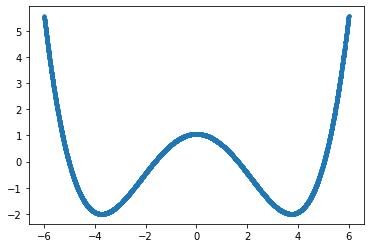

In [2]:
# DATA GENERATION

# hyperparameters
np.random.seed(0)
N = 10**4
low = -6
high = 6
params = [0.5, 0, -3.5, -0.5, 1, -3]

# define target function
def quadratic(x, _params):
    [a, b, c] = _params
    return (a*x+b)**2 + c

def target(x):
    [a1, b1, c1, a2, b2, c2] = params
    h = quadratic(x, [a1,b1,c1])
    return quadratic( h, [a2,b2,c2] ) + h

# training data
X = np.random.uniform(low, high, N)
Y = np.vectorize(target)(X)

# transform to tensor and reshape
X_tensor = torch.reshape(Tensor(X),(N,1))
y_tensor = torch.reshape(Tensor(Y),(N,1))

# visualize
plt.scatter(X, Y, marker=".")
plt.show()

Some graphical intuitions for hyperparameters:
https://www.desmos.com/calculator/pc0szofbfh.

In [3]:
# TRAINING
def train_model(model, X, Y, epochs, batch_size, loss_fn, optimizer):
    # load data
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # train
    for t in range(epochs):
        for (i, (X_batch, y_batch)) in enumerate(data_loader):
            # forward
            pred = model(X_batch.float())
            loss = loss_fn(pred, y_batch)

            # backward
            optimizer.zero_grad()  # clear gradient
            loss.backward()
            optimizer.step()

        if t%5 == 0:
            print(f"\nEpoch: {t+1:n}")
            print(f"loss={loss:.3f}")
            print("_"*50)

In [4]:
# FIRST LAYER STRUCTURE

# nn.Sequential wrapper
class Lambda(nn.Module):
    """
    Input: A Function
    Returns : A Module that can be used inside nn.Sequential
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)
    
def quad_activation(x):
    return x**2

# first_layer
class first_layer_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
    
    def forward(self, x):
        return self.sequential(x)

In [5]:
# HYPER-PARAMETERS OF TRAINING
first_layer = first_layer_model()
loss_fn = nn.MSELoss()

epochs = 30
batch_size = 64

In [6]:
# TRAIN FIRST LAYER
optim1 = optim.Adam(first_layer.parameters())
train_model(first_layer, X, Y, epochs, batch_size, loss_fn, optim1)


Epoch: 1
loss=1.843
__________________________________________________

Epoch: 6
loss=3.065
__________________________________________________

Epoch: 11
loss=2.716
__________________________________________________

Epoch: 16
loss=2.929
__________________________________________________

Epoch: 21
loss=3.009
__________________________________________________

Epoch: 26
loss=1.804
__________________________________________________


[0.6284587383270264, -0.03797328099608421, 0.11613805592060089, -0.6682974696159363]


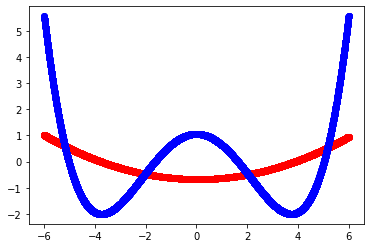

In [7]:
# FIRST LAYLER RESULT
first_layer_params = []
for p in first_layer.parameters():
    first_layer_params.append(p.item())
a1,b1,a2,b2 = first_layer_params
print(first_layer_params)

y_pred = first_layer(X_tensor)
plt.scatter(X_tensor.detach().numpy(), y_pred.detach().numpy(), color="red")
plt.scatter(X_tensor.detach().numpy(), y_tensor.detach().numpy(), color="blue")
plt.show()

In [8]:
# SECOND LAYER MODEL
def first_layer_predict(x):
    return a2*(a1*x+b1)**2 + b2

class second_layer_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            # cannot just put model, because that will train model again
            Lambda(first_layer_predict),  # predict a first layer using already trained first-layer model
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
    
    def forward(self, x):
        return self.sequential(x) + first_layer_predict(x)

    

In [9]:
second_layer = second_layer_model()
optim2 = optim.Adam(second_layer.parameters())
train_model(second_layer, X, Y, epochs, batch_size, loss_fn, optim2)


Epoch: 1
loss=2.363
__________________________________________________

Epoch: 6
loss=2.692
__________________________________________________

Epoch: 11
loss=1.510
__________________________________________________

Epoch: 16
loss=0.163
__________________________________________________

Epoch: 21
loss=0.021
__________________________________________________

Epoch: 26
loss=0.013
__________________________________________________


Parameter containing:
tensor([[-2.0669]], requires_grad=True)
Parameter containing:
tensor([0.0875], requires_grad=True)
Parameter containing:
tensor([[1.7167]], requires_grad=True)
Parameter containing:
tensor([-1.9850], requires_grad=True)


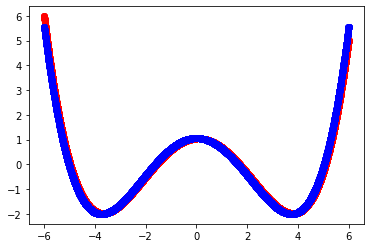

In [10]:
for p in second_layer.parameters():
    print(p)

y_pred_final = second_layer(X_tensor)
plt.scatter(X_tensor.detach().numpy(), y_pred_final.detach().numpy(), color="red")
plt.scatter(X_tensor.detach().numpy(), y_tensor.detach().numpy(), color="blue")
plt.show()

To serve as a comparison, compare the previous freeze-and-train method with the following standard structure: